<a href="https://colab.research.google.com/github/Alephant6/nlp-kaggle/blob/main/d2l/8_5_RNN%E4%BB%8E%E9%9B%B6%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l
!pip install matplotlib==3.0.0

In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
# one-hot
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [5]:
X = torch.arange(10).reshape((2,5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## 8.5.2 初始化模型参数

In [6]:
def get_params(vocab_size, num_hiddens, device):
  num_inputs = num_outputs = vocab_size

  def normal(shape):
    return torch.randn(size=shape, device=device) * 0.01

  # 隐藏层参数
  W_xh = normal((num_inputs, num_hiddens))
  W_hh = normal((num_hiddens, num_hiddens))
  b_h = torch.zeros(num_hiddens, device=device)
  # 输出层参数
  W_hq = normal((num_hiddens, num_outputs))
  b_q = torch.zeros(num_outputs, device=device)
  # 附加梯度
  params = [W_xh, W_hh, b_h, W_hq, b_q]
  for param in params:
    param.requires_grad_(True)
  return params
  

## 8.5.3 循环神经网络模型

In [7]:
def init_rnn_state(batch_size, num_hiddens, device):
  return (torch.zeros((batch_size, num_hiddens), device=device),)

In [8]:
def rnn(inputs, state, params):
  W_xh, W_hh, b_h, W_hq, b_q = params
  H, = state
  outputs = []
  for X in inputs:
    H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
    Y = torch.mm(H, W_hq) + b_q
    outputs.append(Y)
  return torch.cat(outputs, dim=0), (H,)

In [9]:
class RNNModelScratch:
  def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
    self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
    self.params = get_params(vocab_size, num_hiddens, device)
    self.init_state, self.forward_fn = init_state, forward_fn

  def __call__(self, X, state):
    X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
    return self.forward_fn(X, state, self.params)

  def begin_state(self, batch_size, device):
    return self.init_state(batch_size, self.num_hiddens, device)

In [10]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

## 8.5.4 预测

In [11]:
def predict_ch8(prefix, num_preds, nut, vocab, device):
  state = net.begin_state(batch_size=1, device=device)
  outputs = [vocab[prefix[0]]]
  get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
  for y in prefix[1:]:
    _, state = net(get_input(), state)
    outputs.append(vocab[y])
  for _ in range(num_preds):
    y, state = net(get_input(), state)
    outputs.append(int(y.argmax(dim=1).reshape(1)))
  return ''.join([vocab.idx_to_token[i] for i in outputs])

In [12]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller txzatsi<unk>ez'

## 8.5.5 裁剪梯度

In [13]:
def grad_clipping(net, theta):
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params
  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

## 8.5.6 训练

In [15]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
  state, timer = None, d2l.Timer()
  metric = d2l.Accumulator(2)
  for X, Y in train_iter:
    if state is None or use_random_iter:
      state = net.begin_state(batch_size=X.shape[0], device=device)
    else: 
      if isinstance(net, nn.Module) and not isinstance(state, tuple):
        state.detach_()
      else:
        for s in state:
          s.detach_()
    y = Y.T.reshape(-1)
    X, y = X.to(device), y.to(device)
    y_hat, state = net(X, state)
    l = loss(y_hat, y.long()).mean()
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      l.backward()
      grad_clipping(net, 1)
      updater.step()
    else:
      l.backward()
      grad_clipping(net, l)
      updater(batch_size=1)
    metric.add(l * y.numel(), y.numel())
  return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()




In [16]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
  loss = nn.CrossEntropyLoss()
  animator = d2l.Animator(xlabel='epoch', ylabel='perplexity', legend=['train'], xlim=[10, num_epochs])
  
  if isinstance(net, nn.Module):
    updater = torch.optim.SGD(net.parameters(), lr)
  else: 
    updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
  predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
  for epoch in range(num_epochs):
    ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter)
    if (epoch+1) % 10 == 0:
      print(predict('time traveller'))
      animator.add(epoch + 1, [ppl])
  print(f'困惑度：{ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
  print(predict('time traveller'))
  print(predict('traveller'))
      

困惑度：1.0, 79942.1 词元/秒 cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


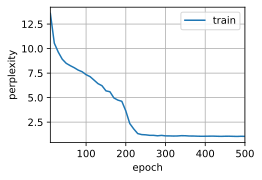

In [17]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度：1.4, 75560.1 词元/秒 cuda:0
time traveller held in his hand was a glitteringmetallic framewo
traveller held in his hand was a glitteringmetallic framewo


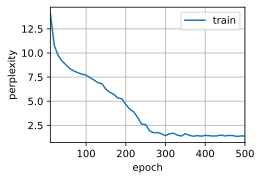

In [19]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)